## LIME and VisualBackProp

## Importing and the network:

See Tutorial 01

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from ./Models/MNIST_model
Prediction is: 4


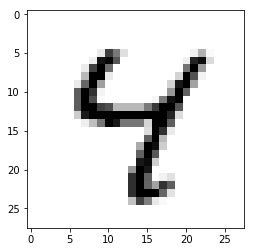

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import Mnist_net as mn
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

data = input_data.read_data_sets('data/MNIST/', one_hot=True)
structure =np.array([[8,8,0,0],[8,4,0,0],[4,4,0,0],[2,14,0,0]])
netsize = len(structure)

net = mn.network()
net.setup(load = "./Models/MNIST_model",structure=structure, data = data, offset=0)
#net.optimize(8000)
#net.save()

im=data.test.images[6]
prediction = net.give_class(im)
print("Prediction is: %d"%prediction)
net.plot_image(im)

## LIME

First Import LIME it is it is important to install from a local directory which contains the file "lime_image_afl33", this is the version I have edited. Install with "python setup.py install" from inside the local directory (pip uninstall any other versions).

In [6]:
#if we we were using the full lime package we would use 
#import lime 
#from lime import lime_image

#but for this we only need the version I have edited
import lime_image_afl33

Convert the image to a 3D array for the lime function, only the Red channel is used when Mnist_net gets used on an RGB image

In [9]:
#lime requires an rgb image to work - this code makes the image supplied look like an rgb image
#but really only one of the channels will be used (so there is no need to invert with 1-)

image = im.reshape(net.img_shape)
image = np.dstack([image.astype(np.float32)] * 3)
#create a lime image explainer
explainer = lime_image_afl33.LimeImageExplainer()

#check that the prediction hasn't changed 
net.give_class(im)

4

The LIME explaination has 3 steps:

1) Get an explaination for all classes by manipulating a single image many times (this takes the longest). Here the parameters are:

        •	The input image is “image”
        •	The classifier is a function of the form “net.give_prob(image)”
        •	Masked pixels will be [0,0,0] (white).
        •	Explanation masks will be saved for the top 10 (all) results
        •	The maximum number of important features (super-pixels) in the binary mask is 522 
        •	100000 samples are taken
        •	The maximum size of a super-pixel is 0 – this forces pixel level detail
        •	The deletion method will be “mask”.
        •	At on average 1% of super-pixels will be masked each iteration


In [11]:
%%time
#get the lime explaination.
explanation = explainer.explain_instance(image,
                                         net.give_prob,
                                         top_labels=10,
                                         hide_color=[0,0,0],
                                         num_features=522,
                                         num_samples=100000,
                                         qs_max_dist=0,
                                         method='inverse',
                                         change_fraction = 0.01)

Wall time: 6min 2s


2) Next the mask is generated, along with the detailed heatmap. Yellow gives evidence for the class, dark blue gives evidence against, the light blue are the least important pixels. There are options to only show positive, to reduce the number of features and to hide the parts of the image which are not positive evidence. 

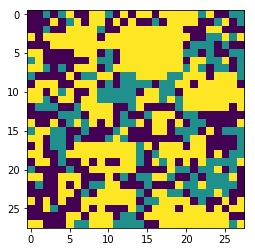

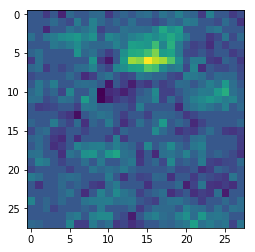

In [12]:
label = 4
temp, mask = explanation.get_image_and_mask(label,
                                            positive_only=False,
                                            num_features=522,
                                            hide_rest=False)

plt.imshow(mask)
plt.show()

segments = explanation.segments #get the superpixels
exp = explanation.local_exp[label] #get the explaination 
heatmap = np.zeros(segments.shape)
image = explanation.image
#for each superpixel set value to the explaination value
for f, w in exp[:28*28]:
    heatmap[segments == f] = w
    temp[segments == f] = image[segments == f].copy()
    temp[segments == f, 0] = np.max(image)

#normalise and show
heatmap=heatmap-np.amin(heatmap)
heatmap=heatmap/np.amax(heatmap)
plt.imshow(heatmap)

3) Analyse the results. Here the contrast is boosted before the mask is overlayed onto the image

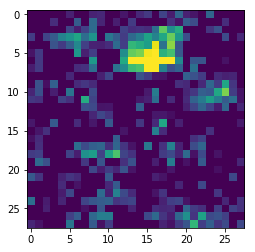

In [13]:
bandsize = 0.4
bandmid = 0.5
high_contrast = heatmap-(bandmid+bandsize/2)
high_contrast =high_contrast*(high_contrast<0).astype(int)+bandsize
high_contrast =high_contrast*(high_contrast>0).astype(int)
high_contrast = high_contrast/bandsize
plt.imshow(high_contrast)
four_heatmap=high_contrast

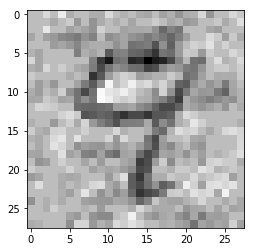

In [14]:
overlay = np.multiply(0.5-image,0.5-np.dstack([four_heatmap.astype(np.float32)] * 3))
overlay =overlay-np.amin(overlay)
overlay =overlay/np.amax(overlay)
plt.imshow(overlay)

Different masks can be compared, for example the heatmap for a 4 and for a 7:

In [ ]:
label = 7
temp, mask = explanation.get_image_and_mask(label,
                                            positive_only=False,
                                            num_features=28*28,
                                            hide_rest=False)

plt.imshow(mask)
plt.show()

segments = explanation.segments
exp = explanation.local_exp[label]
heatmap = np.zeros(segments.shape)
image = explanation.image

for f, w in exp[:28*28]:
    heatmap[segments == f] = w
    temp[segments == f] = image[segments == f].copy()
    temp[segments == f, 0] = np.max(image)

heatmap=heatmap-np.amin(heatmap)
heatmap=heatmap/np.amax(heatmap)
plt.imshow(heatmap)

In [ ]:
bandsize = 0.4
bandmid = 0.5
high_contrast = heatmap-(bandmid+bandsize/2)
high_contrast =high_contrast*(high_contrast<0).astype(int)+bandsize
high_contrast =high_contrast*(high_contrast>0).astype(int)
high_contrast = high_contrast/bandsize
plt.imshow(high_contrast)
seven_heatmap=high_contrast

Look at the difference between the high contrast heatmaps:

In [ ]:
heatmap =(four_heatmap-seven_heatmap)
plt.imshow(heatmap)

## VisualBackProp
(Using the same network and image initialised at the beginning of the tutorial)

First let's have a look at the convolutional layer outputs, and the averaged outputs

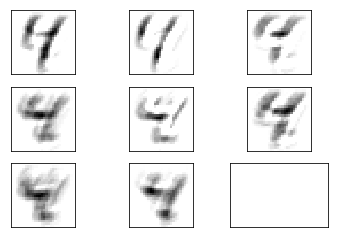

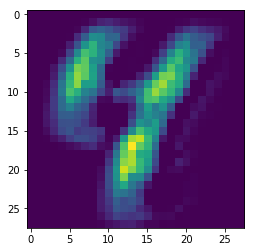

In [15]:
net.plot_conv_layer(net.layers[0],im)
temp = net.average_output(net.layers[0],im)

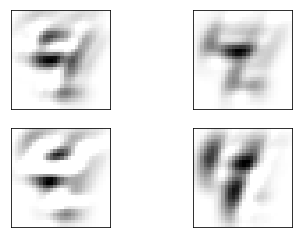

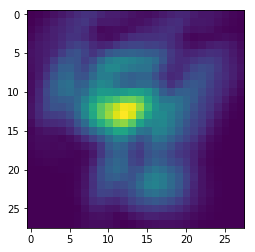

In [17]:
net.plot_conv_layer(net.layers[1],im)
temp = net.average_output(net.layers[1],im)

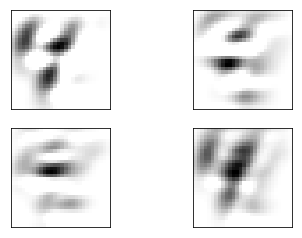

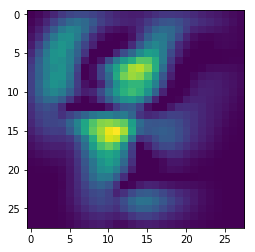

In [18]:
net.plot_conv_layer(net.layers[2],im)
temp = net.average_output(net.layers[2],im)

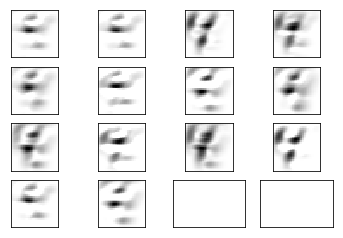

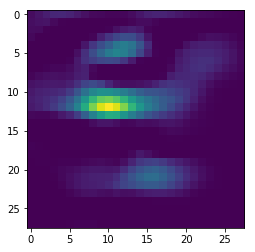

In [19]:
net.plot_conv_layer(net.layers[3],im)
temp = net.average_output(net.layers[3],im)

Thanks to the inbuilt "average_output" function the whole VisualBackProp algorithm can be reproduced using only a few lines of code (and the  scipy library)

In [ ]:
from scipy import signal

In [22]:
%%time
temp = net.average_output(net.layers[netsize-1],im,suppress_out = True)
for i in range(netsize-2,-1,-1):
    temp = scipy.signal.convolve2d(temp,np.ones([structure[i][0],structure[i][0]]),'same')
    temp = np.multiply(temp,net.average_output(net.layers[i],im,suppress_out = True))



Wall time: 39 ms


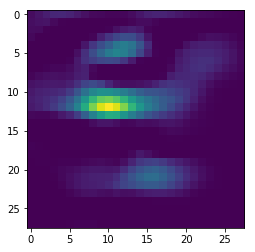

In [20]:
plt.imshow(temp)

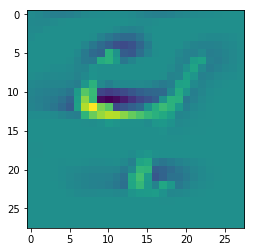

In [21]:
plt.imshow(np.multiply(temp,im.reshape(28,28)-0.5))

In [ ]:
temp = np.multiply(temp,im.reshape(28,28)-0.5)
temp = temp - np.amin(temp)
temp = temp/np.amax(temp)

In [ ]:
from scipy import signal
#get the last layer output
explain = net.average_output(net.layers[netsize-1],im,suppress_out = True)

for i in range(netsize-2,-1,-1):
    #perform the convolution, the output should be the same size as the previous layer
    explain = scipy.signal.convolve2d(explain,np.ones([structure[i][0],structure[i][0]]),'same')
    #perform the multiplication
    explain = np.multiply(explain,net.average_output(net.layers[i],im,suppress_out = True))

#give the final explaination
plt.imshow(explain)



In [ ]:
structure =np.array([[8,8,0,0],[8,4,0,0],[4,4,0,0],[2,14,0,0]])
netsize = len(structure)
net = mn.network()
net.setup(load = "./Models/offset_example" ,structure=structure, data = data, offset= -0.5)